Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

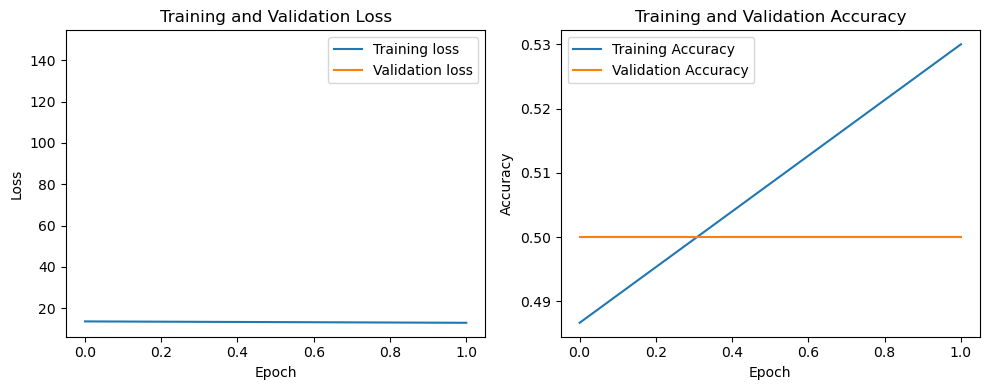

In [5]:

# VGG19をベースとした転移学習を使用して、特定の画像分類タスク（二値分類）を行うためのものです。指定されたディレクトリから画像データを読み込み、前処理を行った後、モデルを構築し、訓練し、評価
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import glob
from PIL import Image


# データの読み込みと前処理
img_size = 200
channels = 3
input_shape = (img_size, img_size, channels)

def load_images(image_dir, label):
    images = []
    labels = []
    for f in os.listdir(image_dir):
        img = img_to_array(load_img(os.path.join(image_dir, f), target_size=input_shape[:2]))
        images.append(img)
        labels.append(label)
    images = np.array(images).astype('float32') / 255.0
    labels = tf.keras.utils.to_categorical(labels, 2)
    return images, labels

# データセットの読み込み
path1_under = "/path/train"
path1_over = "/path/train"
path2_under = "/path/test"
path2_over = "/path/test"


x_train, y_train = load_images(path1_under, 0)
x_train_over, y_train_over = load_images(path1_over, 1)
x_train = np.concatenate((x_train, x_train_over))
y_train = np.concatenate((y_train, y_train_over))

x_val, y_val = load_images(path2_under, 0)
x_val_over, y_val_over = load_images(path2_over, 1)
x_val = np.concatenate((x_val, x_val_over))
y_val = np.concatenate((y_val, y_val_over))


# モデルの構築
def cross_entropy_error(y_true, y_pred):
    return -K.sum(y_true * K.log(y_pred) * 1.2 + (1 - y_true) * K.log(1 - y_pred))

# モデルの構築
def build_model(input_shape):
    WEIGHTS_PATH_NO_TOP = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    input_tensor = Input(shape=input_shape)
    base_model = VGG19(weights=WEIGHTS_PATH_NO_TOP, include_top=False, input_tensor=input_tensor)
    x = Flatten()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=x)

    # カスタム損失関数を使用してモデルをコンパイル
    model.compile(optimizer=RMSprop(lr=0.001), loss=cross_entropy_error, metrics=['accuracy'])
    
    return model

model = build_model(input_shape=(img_size, img_size, channels))
model.summary()



# 訓練
epochs = 2
batch_size = 8
file_name = "model_output"

# コールバックの設定
model_checkpoint = ModelCheckpoint(filepath=os.path.join(file_name, 'model_{epoch:02d}.h5'), save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# モデルの訓練
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[model_checkpoint, early_stop, reduce_lr])

# 結果の保存
pd.DataFrame(history.history).to_csv(file_name + '/history.csv')
model.save(file_name + "/final_model.h5")



# 損失のグラフ
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 精度のグラフ
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(file_name + '/training_validation_results.png')
plt.show()


